In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from gym_agro_carbon.models.context import ContextSpec, ContextEncoder
from gym_agro_carbon.models.reward import RewardSpec, RewardModel
from gym_agro_carbon.envs.grid import EnvSpec, AgroCarbonGridEnv

from gym_agro_carbon.evaluation.oracle import build_oracle_policy, oracle_actions_for_observation
from gym_agro_carbon.evaluation.regret import RegretTracker

from gym_agro_carbon.bandits.base import RandomBandit
from gym_agro_carbon.bandits.ucb import UCBBandit

In [3]:
H, W = 8, 10
T = 50

S = 8
M = 7
alpha = 0.6
seed = 123

context_spec = ContextSpec(S=S, M=M)
encoder = ContextEncoder(context_spec)

reward_spec = RewardSpec(
    context_spec=context_spec,
    alpha=alpha,
    sigma_c=0.05,
    sigma_y=0.05,
    tree_carbon_gain=0.50,
    tree_yield_gain=0.10,
)
reward_model = RewardModel(spec=reward_spec, encoder=encoder)

env_spec = EnvSpec(H=H, W=W, T=T, alpha=alpha, S=S, M=M, seed=seed)

env = AgroCarbonGridEnv(env_spec=env_spec, context_spec=context_spec, reward_model=reward_model)

In [4]:
oracle = build_oracle_policy(encoder=encoder, reward_model=reward_model, num_actions=env_spec.num_actions)
regret_tracker = RegretTracker(encoder=encoder, reward_model=reward_model, oracle=oracle)

print("num_contexts:", encoder.spec.num_contexts)
print("oracle best actions (first 10):", oracle.best_action_by_context[:10])

num_contexts: 64
oracle best actions (first 10): [2 2 2 2 2 2 2 2 2 2]


In [5]:
def run_agent(env, agent, T, seed=0):
    obs, info = env.reset(seed=seed)
    agent.reset()
    regret_tracker.reset()

    rewards = []
    regrets = []
    trees = []

    for t in range(T):
        actions = agent.select_actions(obs)
        obs2, R, terminated, truncated, info2 = env.step(actions)

        # update learning agent with LOCAL rewards
        agent.update(obs, actions, info2["reward_grid"])

        # pseudo-regret computed from expected rewards (oracle vs chosen actions)
        step_regret = regret_tracker.update(t=t, obs_context_ids=obs, actions_grid=actions)

        rewards.append(R)
        regrets.append(step_regret)
        trees.append(info2["num_agent_trees"])

        obs = obs2
        if terminated or truncated:
            break

    return {
        "rewards": np.array(rewards, dtype=float),
        "regrets": np.array(regrets, dtype=float),
        "trees": np.array(trees, dtype=int),
        "cum_reward": float(np.sum(rewards)),
        "cum_regret": float(np.sum(regrets)),
    }

In [6]:
random_agent = RandomBandit(context_encoder=encoder, num_actions=env_spec.num_actions, seed=0)
res_random = run_agent(env, random_agent, T=T, seed=seed)

res_random["cum_reward"], res_random["cum_regret"], res_random["trees"][-1]

(3550.842086791992, 339.3291230201721, np.int64(80))

In [7]:
ucb_agent = UCBBandit(context_encoder=encoder, num_actions=env_spec.num_actions, seed=0, exploration_c=1.0)
res_ucb = run_agent(env, ucb_agent, T=T, seed=seed)

res_ucb["cum_reward"], res_ucb["cum_regret"], res_ucb["trees"][-1]

(3666.9294662475586, 247.38169515132904, np.int64(80))

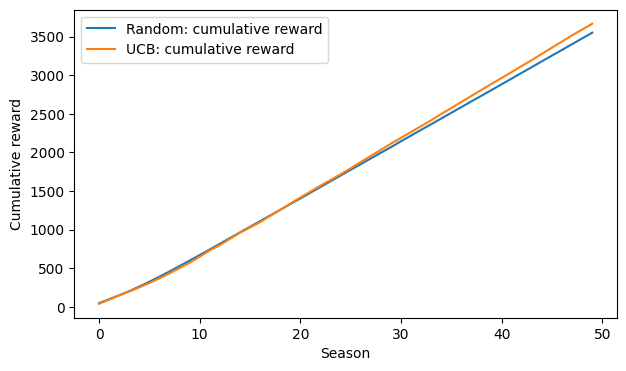

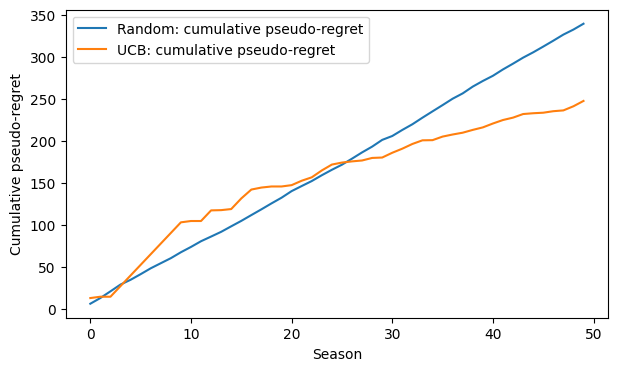

In [8]:
def cumulative(x):
    return np.cumsum(x)

plt.figure(figsize=(7,4))
plt.plot(cumulative(res_random["rewards"]), label="Random: cumulative reward")
plt.plot(cumulative(res_ucb["rewards"]), label="UCB: cumulative reward")
plt.xlabel("Season")
plt.ylabel("Cumulative reward")
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(cumulative(res_random["regrets"]), label="Random: cumulative pseudo-regret")
plt.plot(cumulative(res_ucb["regrets"]), label="UCB: cumulative pseudo-regret")
plt.xlabel("Season")
plt.ylabel("Cumulative pseudo-regret")
plt.legend()
plt.show()

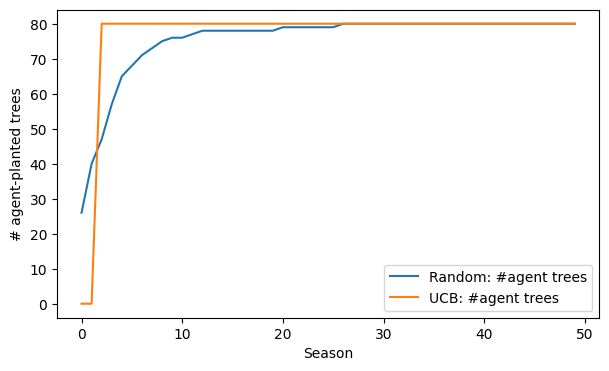

In [9]:
plt.figure(figsize=(7,4))
plt.plot(res_random["trees"], label="Random: #agent trees")
plt.plot(res_ucb["trees"], label="UCB: #agent trees")
plt.xlabel("Season")
plt.ylabel("# agent-planted trees")
plt.legend()
plt.show()